In [ ]:
# Install xgboost4j JAR
!wget https://repo1.maven.org/maven2/ml/dmlc/xgboost4j/0.90/xgboost4j-0.90.jar

--2023-12-08 13:39:04--  https://repo1.maven.org/maven2/ml/dmlc/xgboost4j/0.90/xgboost4j-0.90.jar
Resolving repo1.maven.org (repo1.maven.org)... 199.232.192.209, 199.232.196.209, 2a04:4e42:4c::209, ...
Connecting to repo1.maven.org (repo1.maven.org)|199.232.192.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2353013 (2.2M) [application/java-archive]
Saving to: ‘xgboost4j-0.90.jar’

xgboost4j-0.90.jar  100%[===================>]   2.24M  2.80MB/s    in 0.8s    

2023-12-08 13:39:06 (2.80 MB/s) - ‘xgboost4j-0.90.jar’ saved [2353013/2353013]



In [ ]:
# Install xgboost4j-Spark JAR
!wget https://repo1.maven.org/maven2/ml/dmlc/xgboost4j-spark/0.90/xgboost4j-spark-0.90.jar

--2023-12-08 13:39:06--  https://repo1.maven.org/maven2/ml/dmlc/xgboost4j-spark/0.90/xgboost4j-spark-0.90.jar
Resolving repo1.maven.org (repo1.maven.org)... 199.232.192.209, 199.232.196.209, 2a04:4e42:4c::209, ...
Connecting to repo1.maven.org (repo1.maven.org)|199.232.192.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 429101 (419K) [application/java-archive]
Saving to: ‘xgboost4j-spark-0.90.jar’

xgboost4j-spark-0.9 100%[===================>] 419.04K   811KB/s    in 0.5s    

2023-12-08 13:39:07 (811 KB/s) - ‘xgboost4j-spark-0.90.jar’ saved [429101/429101]



In [ ]:
!pip install pyspark
!pip install xgboost

!pip install google-cloud-storage

!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install newspaper3k nltk
!pip install googlesearch-python

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, unix_timestamp
from pyspark.sql.types import StringType, StructType, StructField, FloatType
import yfinance as yf
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import unix_timestamp, when
from pyspark.ml.stat import Correlation

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from google.cloud import storage
from google.colab import files

from fuzzywuzzy import fuzz
from newspaper import Article, ArticleException
from googlesearch import search
import nltk
import requests
from bs4 import BeautifulSoup
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')





[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Create Spark Session
spark = SparkSession.builder.appName("NiftyPrediction").config("spark.jars", "/content/xgboost4j-0.90.jar,/content/xgboost4j-spark-0.90.jar").getOrCreate()

# Define Nifty symbol
symbol = "INFY"

# Download Nifty data for INFY
data = yf.download(symbol, period="max")

# Access and convert date
data["Date"] = data.index.to_series().dt.strftime("%Y-%m-%d")

# Convert data to Spark DataFrame
data_df = spark.createDataFrame(data)

# Convert Date to date type and create timestamps
data_df = data_df.withColumn("Date", unix_timestamp(col("Date"), "yyyy-MM-dd"))
data_df = data_df.orderBy(col("Date").desc())

# Separate features (date) and label (closing price)
features = ['Date', 'Open', 'High', 'Low', 'Adj Close']
label = "Close"

# Convert features to a single vector
assembler = VectorAssembler(inputCols=features, outputCol="features")
prepared_data = assembler.transform(data_df)

# Get the last 20% of the data
num_data_points = prepared_data.count()
test_data_size = int(num_data_points * 0.2)
testing_data = prepared_data.orderBy(col("Date").desc()).limit(test_data_size)

# Remaining data is training data
training_data = prepared_data.subtract(testing_data)

print("Training data size:", training_data.count())
print("Testing data size:", testing_data.count())


[*********************100%%**********************]  1 of 1 completed
Training data size: 4983
Testing data size: 1245


In [ ]:
data_df.head(10)

[Row(Open=17.670000076293945, High=17.709999084472656, Low=17.579999923706055, Close=17.639999389648438, Adj Close=17.639999389648438, Volume=3340000, Date=1701907200),
 Row(Open=17.799999237060547, High=17.860000610351562, Low=17.65999984741211, Close=17.690000534057617, Adj Close=17.690000534057617, Volume=6891300, Date=1701820800),
 Row(Open=17.59000015258789, High=17.709999084472656, Low=17.389999389648438, Close=17.459999084472656, Adj Close=17.459999084472656, Volume=5016100, Date=1701734400),
 Row(Open=17.84000015258789, High=17.8799991607666, Low=17.639999389648438, Close=17.690000534057617, Adj Close=17.690000534057617, Volume=5588600, Date=1701648000),
 Row(Open=17.469999313354492, High=17.75, Low=17.43000030517578, Close=17.729999542236328, Adj Close=17.729999542236328, Volume=4766000, Date=1701388800),
 Row(Open=17.610000610351562, High=17.690000534057617, Low=17.469999313354492, Close=17.549999237060547, Adj Close=17.549999237060547, Volume=5541400, Date=1701302400),
 Row(

Finding correlation

In [26]:
# Calculate the correlation matrix
prepared_data_feature = prepared_data.drop('Close')
corr_matrix = Correlation.corr(prepared_data_feature, "features").head()

# Extract the correlation matrix as a NumPy array
corr_array = corr_matrix[0].toArray()

# Get the correlation of features with the "Close" column
target_corr = corr_array[:, prepared_data.columns.index("Close")]

# Convert the correlation values to Python float
target_corr = [float(value) for value in target_corr]

# Create a schema for the correlation DataFrame
schema = StructType([
    StructField("Feature", StringType(), True),
    StructField("Correlation", FloatType(), True)
])

# Create a Spark DataFrame for the correlation with "Close"
target_corr_df = spark.createDataFrame(zip(prepared_data_feature.columns, target_corr), schema=schema)

# Order the DataFrame by the "Correlation" column in descending order
target_corr_df = target_corr_df.orderBy("Correlation", ascending=False)

# Show the correlation DataFrame
target_corr_df.show(truncate=False)

+---------+-----------+
|Feature  |Correlation|
+---------+-----------+
|Adj Close|1.0        |
|High     |0.9998142  |
|Low      |0.9996999  |
|Volume   |0.9951713  |
|Open     |0.83760035 |
+---------+-----------+



# Start ML models

### Import required performance metrics for ML models

In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from math import sqrt

### Linear Regression

In [31]:
from pyspark.ml.regression import LinearRegression

# Create a LinearRegression object
lin_reg = LinearRegression(labelCol='Close', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Train the model
model = lin_reg.fit(training_data)

# Make predictions on the testing data
predictions = model.transform(testing_data)


In [ ]:
predicted_values = predictions.select("prediction").toPandas()["prediction"]
actual_values = testing_data.toPandas()['Close']

In [34]:
mse = mean_squared_error(actual_values, predicted_values)
rmse = sqrt(mean_squared_error(actual_values, predicted_values))
r2 = r2_score(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2 score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.4810314477315895
Root Mean Squared Error (RMSE): 0.693564306846589
R2 score: 0.9782182415914193
Mean Absolute Error (MAE): 0.6040881256087988


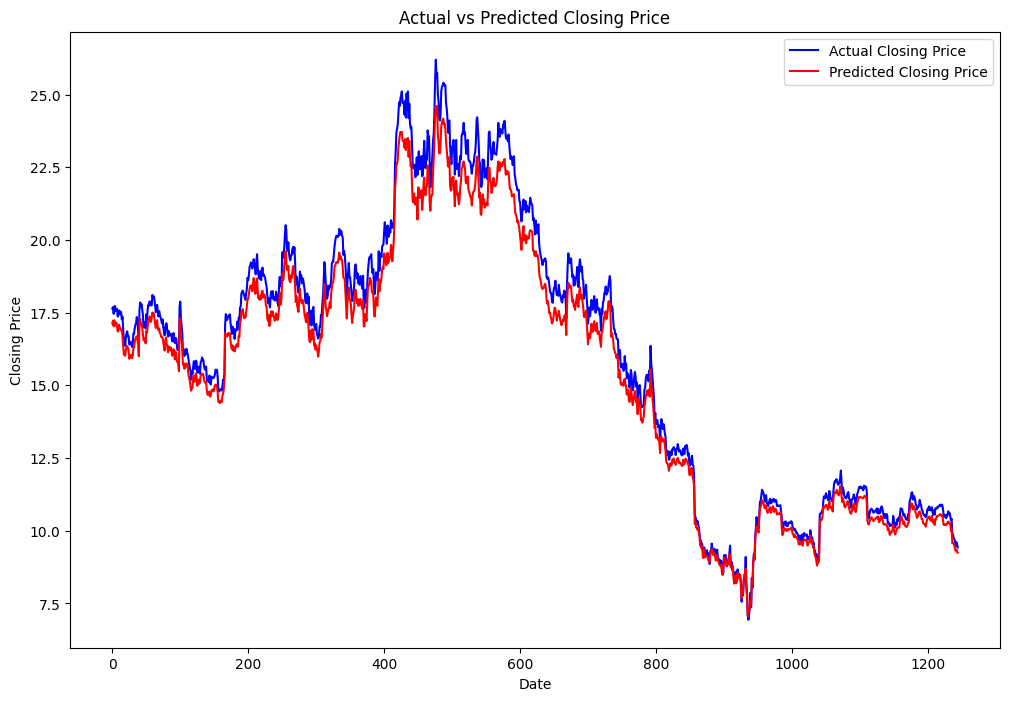

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(actual_values, label="Actual Closing Price", color="blue")
plt.plot(predicted_values, label="Predicted Closing Price", color="red")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Actual vs Predicted Closing Price")
plt.legend()
plt.show()

### RandomForest Model

In [55]:
# Create a Randomforestclassifier object
rf = RandomForestClassifier(labelCol='Close', featuresCol="features", numTrees=50, maxDepth=5)

# Train the model
prepared_data_with_int = training_data.withColumn("Close", col("Close").cast("integer"))
model = rf.fit(prepared_data_with_int)

# Make predictions on the testing data
predictions = model.transform(testing_data)

In [56]:
predicted_values_rf = predictions.select("prediction").toPandas()["prediction"]
actual_values_rf = testing_data.toPandas()['Close']

In [57]:
mse = mean_squared_error(actual_values_rf, predicted_values_rf)
rmse = sqrt(mean_squared_error(actual_values_rf, predicted_values_rf))
r2 = r2_score(actual_values_rf, predicted_values_rf)
mae = mean_absolute_error(actual_values_rf, predicted_values_rf)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2 score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 71.63136169072213
Root Mean Squared Error (RMSE): 8.463531277825004
R2 score: -2.243565513611867
Mean Absolute Error (MAE): 7.094257029184854


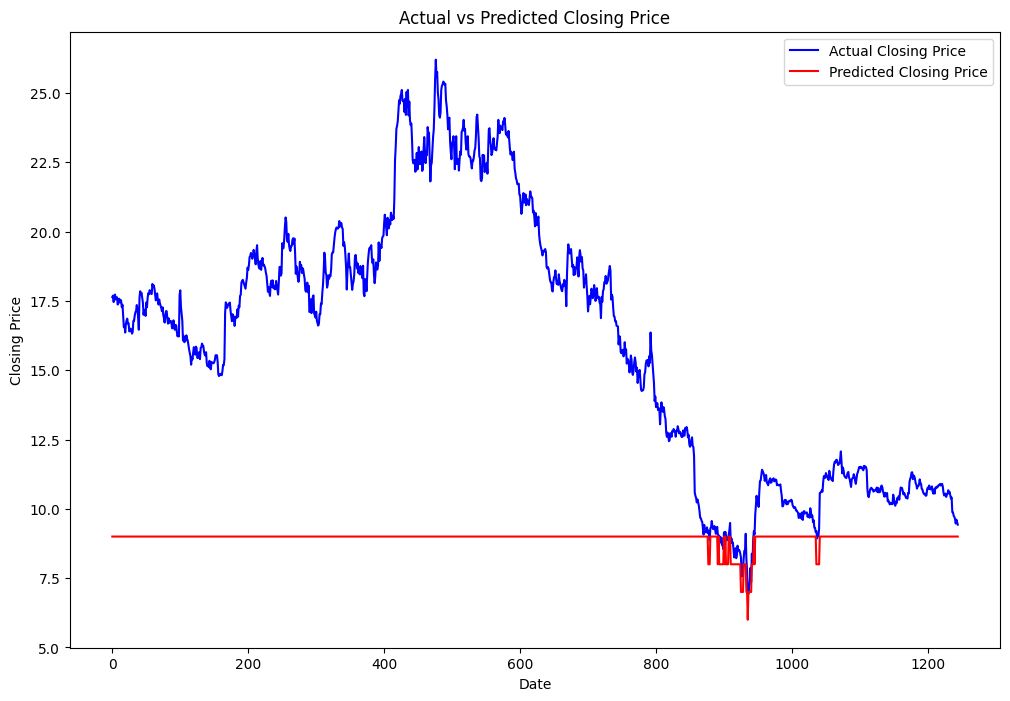

In [58]:
plt.figure(figsize=(12, 8))
plt.plot(actual_values_rf, label="Actual Closing Price", color="blue")
plt.plot(predicted_values_rf, label="Predicted Closing Price", color="red")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Actual vs Predicted Closing Price")
plt.legend()
plt.show()

### XGBoost model

In [63]:
# Import necessary libraries
from xgboost.spark import SparkXGBRegressor
from pyspark.sql.functions import col

# Define the objective and random state
objective = "reg:squarederror"
random_state = 42

# Define the label column for both datasets
df_train_label = training_data.select("Close")
df_test_label = testing_data.select("Close")

# Create an XGBoost regressor
xgboost = SparkXGBRegressor(features_col="features",
  label_col="Close",
  num_workers=2)

# Train the model
model = xgboost.fit(training_data)

# Make predictions
predictions = model.transform(testing_data)



INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 2 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


In [64]:
predicted_values_xg = predictions.select("prediction").toPandas()["prediction"]
actual_values_xg = testing_data.toPandas()['Close']

In [65]:
mse = mean_squared_error(actual_values_xg, predicted_values_xg)
rmse = sqrt(mean_squared_error(actual_values_xg, predicted_values_xg))
r2 = r2_score(actual_values_xg, predicted_values_xg)
mae = mean_absolute_error(actual_values_xg, predicted_values_xg)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2 score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 54.97027545047866
Root Mean Squared Error (RMSE): 7.41419418753506
R2 score: -1.4891288608298425
Mean Absolute Error (MAE): 5.886221995219648


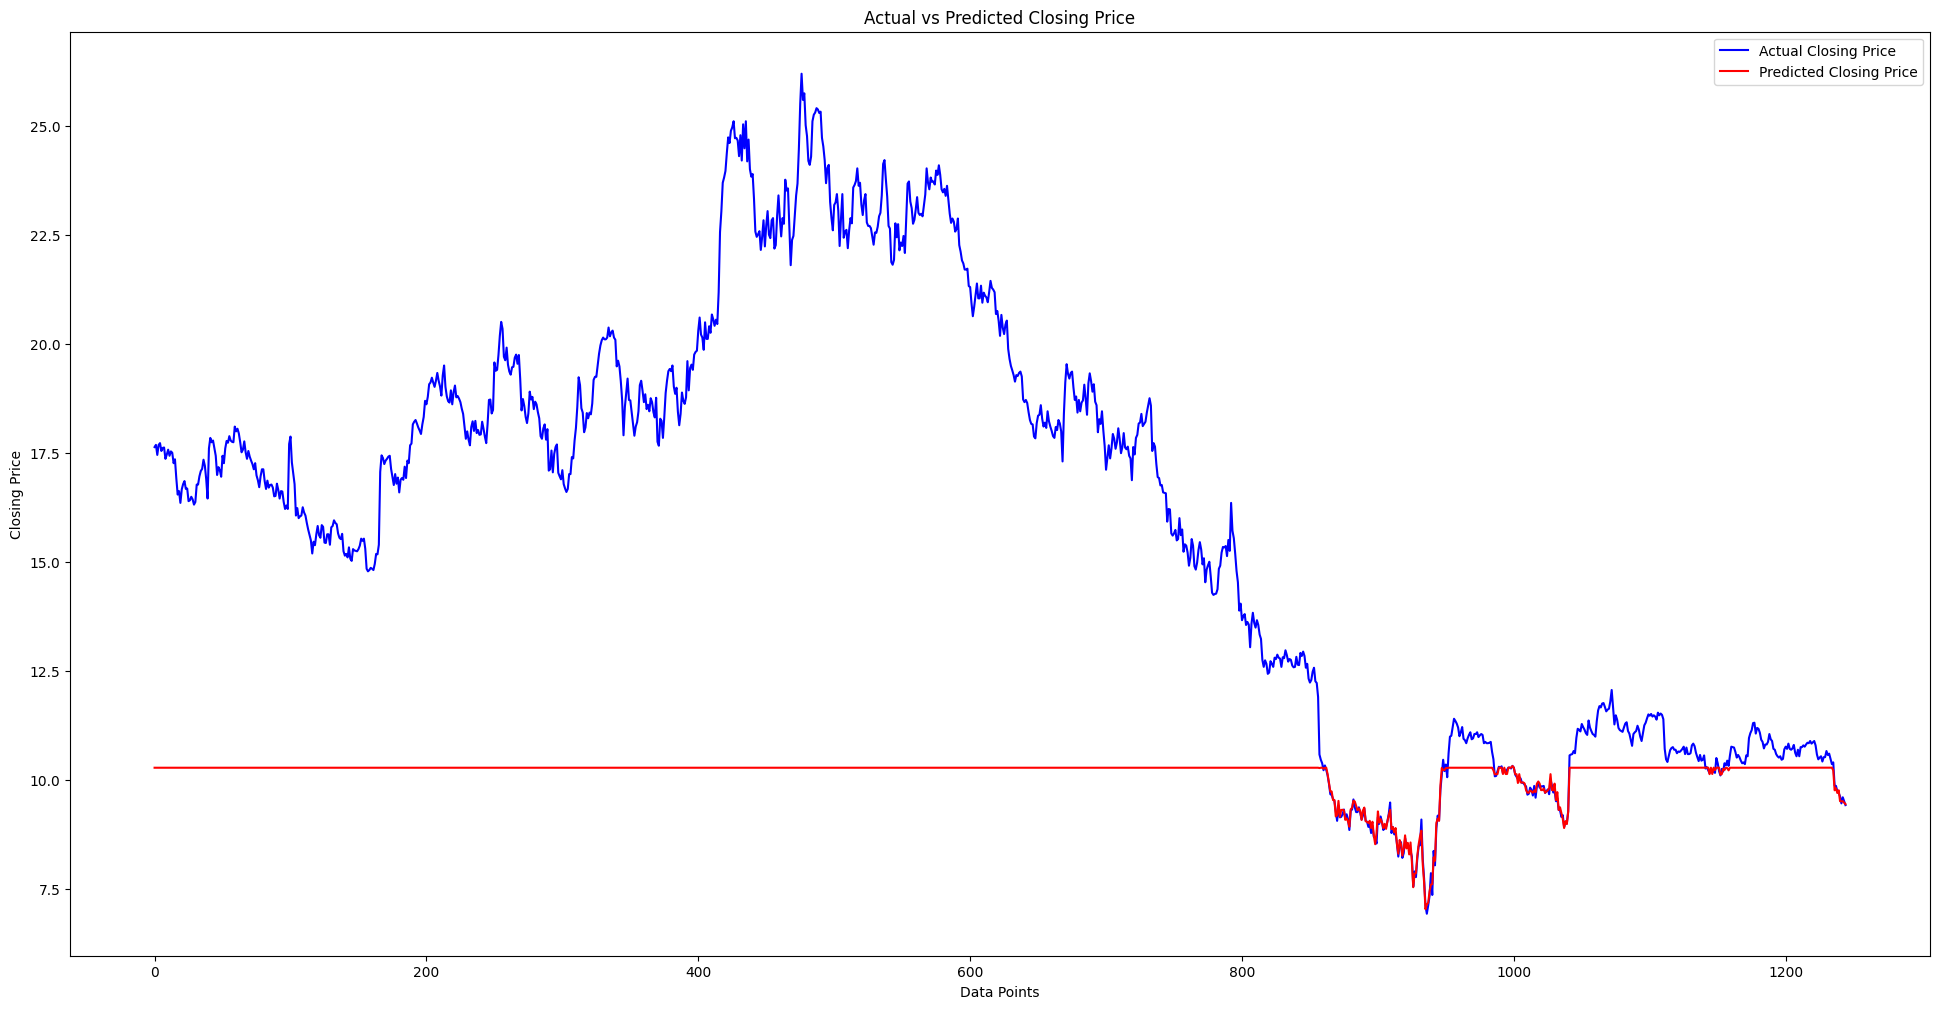

In [66]:
plt.figure(figsize=(24, 12))
plt.plot(actual_values_xg.values, label="Actual Closing Price", color="blue")
plt.plot(predicted_values_xg, label="Predicted Closing Price", color="red")
plt.xlabel("Data Points")
plt.ylabel("Closing Price")
plt.title("Actual vs Predicted Closing Price")
plt.legend()
plt.show()

# Sentiment Analysis

Before working with trained prepare data, lets have a look at market sentiment for this company

In [ ]:
file_path = '/content/Nifty_sector.csv'

# Read the CSV file into a Spark DataFrame
company_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Get company name in 'symbol' variable
symbols = company_df.select(col("Symbol")).rdd.flatMap(lambda x: x).collect()

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

def fetch_article_text(url):
    ''' This function fetchs article text from a webpage using newspaper3k '''
    article = Article(url)
    article.download()
    article.parse()
    return article.text

def analyze_sentiment_for_symbol(symbol):
    ''' This function is to analyze sentiment for news headlines for a given symbol '''
    query = f"{symbol} independent market sentiment"

    # Perform a Google search and get the first result
    for url in search(query, num_results=10):
        try:
            # Fetch the article text from the webpage
            article_text = fetch_article_text(url)

            # Perform sentiment analysis on the article text
            sentiment_score = sia.polarity_scores(article_text)['compound']

            # Classify overall sentiment as positive, negative, or neutral
            overall_sentiment = 'Positive' if sentiment_score > 0 else 'Negative' if sentiment_score < 0 else 'Neutral'

            return overall_sentiment
        except ArticleException as e:
            print(f"Not possible download article from {url} due to copyright restriction")

    return None

# Analyze sentiment for the symbols
results = []
for symbol in symbols:
  sentiment = analyze_sentiment_for_symbol(symbol)
  if sentiment:
      result_entry = {"Symbol":symbol.upper(), "Sentiment": sentiment}
      results.append(result_entry)

  else:
      result_entry = {"Symbol": symbol.upper(), "Sentiment": "Not found"}
      results.append(result_entry)

# Define the schema for the company sentiment DataFrame
schema = StructType([
    StructField("Symbol", StringType(), True),
    StructField("Sentiment", StringType(), True),
])

# Create the DataFrame
stock_sentiments = spark.createDataFrame(results, schema=schema)

stock_sentiments.show()

Not possible download article from https://www.barrons.com/market-data/stocks/infy due to copyright restriction
Not possible download article from https://www.barrons.com/market-data/stocks/rdy due to copyright restriction
+----------+---------+
|    Symbol|Sentiment|
+----------+---------+
|  HDFCBANK| Positive|
|      INFY| Positive|
|       ITC| Positive|
|BHARTIARTL| Positive|
|     TITAN| Positive|
| TATASTEEL| Positive|
|ULTRACEMCO| Positive|
|      NTPC| Positive|
|ADANIPORTS| Positive|
|      ONGC| Positive|
|   DRREDDY| Positive|
| EICHERMOT| Positive|
|       UPL| Positive|
+----------+---------+



Now, lets have a look at market sentiment for these sectors

In [ ]:
# Get Industry names in 'Industry' variable
sectors = company_df.select("Industry").distinct().rdd.flatMap(lambda x: x).collect()

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

def fetch_article_text(url):
    ''' This function fetchs article text from a webpage using newspaper3k '''
    article = Article(url)
    article.download()
    article.parse()
    return article.text

def analyze_sentiment_for_sector(sector):
    ''' This function is to analyze sentiment for news headlines for a given symbol '''
    query = f"{sector} independent market sentiment"

    # Perform a Google search and get the first result
    for url in search(query, num_results=10):
        try:
            # Fetch the article text from the webpage
            article_text = fetch_article_text(url)

            # Perform sentiment analysis on the article text
            sentiment_score = sia.polarity_scores(article_text)['compound']

            # Classify overall sentiment as positive, negative, or neutral
            overall_sentiment = 'Positive' if sentiment_score > 0 else 'Negative' if sentiment_score < 0 else 'Neutral'

            return overall_sentiment
        except ArticleException as e:
            print(f"Not possible download article from {url} due to copyright restriction")

    return None

# Analyze sentiment for the symbols
results = []
for sector in sectors:
  sentiment = analyze_sentiment_for_sector(sector)
  if sentiment:
      result_entry = {"Industry":sector, "Sentiment": sentiment}
      results.append(result_entry)

  else:
      result_entry = {"Industry": sector, "Sentiment": "Not found"}
      results.append(result_entry)

# Define the schema for the sector sentiment DataFrame
schema = StructType([
    StructField("Industry", StringType(), True),
    StructField("Sentiment", StringType(), True),
])


# Create a DataFrame from the results list
industry_sentiments = spark.createDataFrame(results, schema=schema)

industry_sentiments.show()

Not possible download article from https://www.reuters.com/markets/europe/crude-oil-fuels-draw-funds-sentiment-shifts-2023-08-07/ due to copyright restriction
Not possible download article from https://www.cbre.co.uk/insights/articles/healthcare-market-sentiment-survey due to copyright restriction
Not possible download article from https://www.sciencedirect.com/science/article/pii/S2215098621000070 due to copyright restriction
+--------------------+---------+
|            Industry|Sentiment|
+--------------------+---------+
|            Services| Positive|
|           Oil & Gas| Positive|
|     Metals & Mining| Positive|
|   Telecommunication|  Neutral|
|  Financial Services| Positive|
|               Power| Positive|
|          Healthcare| Positive|
|                FMCG|  Neutral|
|Information Techn...|  Neutral|
|Construction Mate...| Positive|
|           Chemicals| Positive|
|          Automobile| Positive|
|   Consumer Durables|  Neutral|
+--------------------+---------+



Join both and create a relevant dataframe for sentiment analysis

In [ ]:
# Join the DataFrames on the common columns
joined_df = company_df.alias("company").join(stock_sentiments.alias("stock"), col("company.Symbol") == col("stock.Symbol")).join(industry_sentiments.alias("industry"), col("company.Industry") == col("industry.Industry"))

# Define the logic for the 'Sentiment' column
joined_df = joined_df.withColumn(
    "Final_sentiment",
    when(
        (col("stock.Sentiment") == "Positive") & (col("industry.Sentiment") == "Positive"),
        "Positive"
    ).when(
        (col("stock.Sentiment") == "Negative") & (col("industry.Sentiment") == "Negative"),
        "Negative"
    ).when(
        (col("stock.Sentiment") == "Positive") & (col("industry.Sentiment") == "Negative"),
        "Neutral"
    ).when(
        (col("stock.Sentiment") == "Negative") & (col("industry.Sentiment") == "Positive"),
        "Neutral"
    ).otherwise("Neutral")
)


# Select only the relevant columns
final_sentiment_df = joined_df.select(
    col("company.Symbol").alias("Symbol"),
    col("company.Industry").alias("Industry"),
    col("Final_sentiment")
)

# Show the final DataFrame
final_sentiment_df.show()

+----------+--------------------+---------------+
|    Symbol|            Industry|Final_sentiment|
+----------+--------------------+---------------+
| EICHERMOT|          Automobile|       Positive|
|       UPL|           Chemicals|       Positive|
|ULTRACEMCO|Construction Mate...|       Positive|
|     TITAN|   Consumer Durables|        Neutral|
|       ITC|                FMCG|        Neutral|
|  HDFCBANK|  Financial Services|       Positive|
|   DRREDDY|          Healthcare|       Positive|
|      INFY|Information Techn...|        Neutral|
| TATASTEEL|     Metals & Mining|       Positive|
|      ONGC|           Oil & Gas|       Positive|
|      NTPC|               Power|       Positive|
|ADANIPORTS|            Services|       Positive|
|BHARTIARTL|   Telecommunication|        Neutral|
+----------+--------------------+---------------+

